# Visual Transformer (ViT) in PyTorch
Based of the Vision Transformer Paper by Google Brain Research Team.

86 million parameters

In [11]:
# importing necessary libraries
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 13, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 14, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.0
torchvision version: 0.14.0


In [12]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    # package to get summary of models
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install - q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from modulo import data_setup, engine
    from helpers import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https: // github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py .  # get the helper_functions.py script
    !rm - rf pytorch-deep-learning
    from modulo.going_modular import data_setup, engine
    from helpers import download_data, set_seeds, plot_loss_curves


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

Data Collection

In [14]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path


[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [15]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"


### Preprocess data

Turn images into tensors using same code as paper

In [16]:
# download data

# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")


Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [17]:
# Set the batch size
BATCH_SIZE = 32  # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,  # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names


(<torch.utils.data.dataloader.DataLoader at 0x11d258910>,
 ['pizza', 'steak', 'sushi'])

In [18]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label


(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

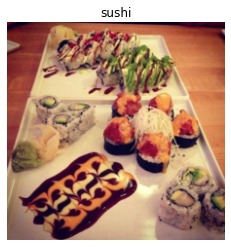

In [19]:
# Plot image with matplotlib
# rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)


## How the model works

Original Transformer paper was based of text sequences. We turn image into sequence by flattening image into patches. Then we embed patches and then add positional embedding and a class token embedding. Then a series of transformer encoder to learn what is inside an image. Then we pass that into a MLP head, and then it gives us the output.

### Architecture
PatchEmbedding(): Turn the images into patches
Transformer Encoder Layer: Alternating Multi-Self-Attention Layers and MLP blocks.
Stack Multiple Transformer encoder layers on top of each other
MLP Head
Put it All Together to create the ViT.

### Patch Embedding Layer
Creates the patch embedding by doing a convolutional layer over an image and flattening those convolutional feature maps.

Kernal size of patch size. 

Stride length of patch size. 

This allows us to embed our image using a convolutional layer that creates a linear projection of flattened patches. This turns the image pixels into a learnable representation (embedding). 

Instead of using RGB, we use embedding so our model can learn representations of out image. 


In [20]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables

    def __init__(self,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768):
        super().__init__()

        self.patch_size = patch_size

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=self.patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2,  # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1)


In [21]:
patch_embedding = PatchEmbedding()
patch_embedding_output = patch_embedding(rand_image_tensor)
print(f"input shape: {rand_image_tensor.shape}")
print(f"Output shape: {patch_embedding_output.shape}")

NameError: name 'rand_image_tensor' is not defined

### Transformer Encoder Layer

Alternating MSA and MLP blocks.

Using TRANSFORMERENCODERLAYER() from PyTorch.
- Made up of self attention, multi head attention, and feedforward (dense, MLP) networks
- MLP contains two layers with a GELU non-linearity.

I will be using this rather than the transformer I made my self.

In [ ]:
# batch size, color channels, height, width
rand_image_tensor = torch.randn(1,3,224,224)
rand_image_tensor.shape

torch.Size([1, 3, 224, 224])

In [ ]:
# the paper uses a dimensions of 768, or embedding size for ViT base
# Dropout is regularization by randomly dropping out connection between layers. Remaining layers are now more generalizable.
# *** insert image here
# *** add GELU image from pytorch website
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, nhead=12, dim_feedforward=3072, dropout=0.1, activation="gelu", batch_first=True, norm_first=True)
transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

### Stacking 12 layers of Transformer encoder on top of each other from the paper, which uses a stack of 12 layers.

We can do so using nn.TransformerEncoder

In [ ]:
transformer_encoder = nn.TransformerEncoder(encoder_layer=transformer_encoder_layer, num_layers=12)

transformer_encoder

TransformerEncoder(
  (layers): ModuleList(
    (0): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=3072, out_featu

### Creating the ViT

A learnable classification token is added to the model in order to perform classification.

In [ ]:
class ViT(nn.Module):
  def __init__(self, img_size=224, patch_size=16, embedding_dim=768, dropout=0.1, mlp_size=3072, num_transformer_layers = 12, num_heads=12, num_channels=3, num_classes=1000):
    super().__init__()
    # print("hi")

    assert img_size % patch_size == 0, "Image size must be divisible by patch size"

    # patch embedding
    self.patch_embedding = PatchEmbedding(in_channels=num_channels, patch_size=patch_size, embedding_dim=embedding_dim)

    # class token, requires_grad makes it learnable
    self.class_token = nn.Parameter(torch.randn(1,1,embedding_dim), requires_grad=True)

    # positional embedding
    num_patches = (img_size * img_size // patch_size**2) # N=HW/P^2
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embedding_dim))

    # patch and positional embedding dropout
    self.embedding_dropout = nn.Dropout(p=dropout)

    # Single transformer encoder layer
    self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=mlp_size, activation="gelu", batch_first=True,
    norm_first=True)

    # Stack of Transformer Encoder Layers
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=mlp_size, activation="gelu", batch_first=True,
                                                                                              norm_first=True), num_layers=12)

    # MLP head
    self.mlp_head = nn.Sequential(
      #get info about layer norm from papers w/ code
      nn.LayerNorm(normalized_shape=embedding_dim),
      nn.Linear(in_features=embedding_dim, out_features=num_classes)
    )


  def forward(self, x):
    batch_size = x.shape[0]

    # Patch embedding
    x = self.patch_embedding(x)

    # Expand the class token across all the batch size and infer the dimension 
    class_token = self.class_token.expand(batch_size, -1, -1)

    # Prepend class token to patch embedding
    x = torch.cat((class_token, x), dim=1)

    # add pos_emb to class_token
    x = self.positional_embedding + x
    print(x.shape)

    # Dropout Add
    x = self.embedding_dropout(x)

    # Pass embedding through transformer stack
    x = self.transformer_encoder(x)

    # Pass first token to MLP head
    x = self.mlp_head(x[:,0])

    return x

In [ ]:
demo_img = torch.randn(32,3,224,224) 
print(demo_img.shape)

vit = ViT(num_classes=len(class_names))
vit(demo_img)

torch.Size([32, 3, 224, 224])
torch.Size([32, 197, 768])


tensor([[ 0.2283,  0.0802, -0.7142],
        [ 0.2601,  0.1633, -0.4209],
        [ 0.2553, -0.5217, -1.0118],
        [ 0.4093, -0.1271, -0.7528],
        [ 0.1728, -0.2613, -0.8472],
        [ 0.2187,  0.0765, -0.8131],
        [ 0.4672, -0.1950, -0.9200],
        [ 0.2560,  0.3770, -0.8075],
        [ 0.2505,  0.0825, -0.8534],
        [ 0.2871, -0.2033, -0.6935],
        [ 0.2887,  0.0361, -0.4170],
        [ 0.1647, -0.0886, -0.7537],
        [ 0.5177, -0.2890, -0.6019],
        [-0.0424, -0.0099, -0.5542],
        [ 0.6241, -0.2538, -0.8078],
        [-0.0087, -0.2060, -0.5199],
        [ 0.2956,  0.0273, -0.7227],
        [ 0.0300,  0.0512, -0.6969],
        [ 0.0680, -0.0749, -0.7172],
        [ 0.2609, -0.1485, -0.4220],
        [ 0.3395,  0.0364, -0.6158],
        [-0.0534, -0.1574, -0.8294],
        [ 0.4851, -0.1919, -0.7795],
        [ 0.3416, -0.1231, -0.7072],
        [ 0.2780, -0.0190, -0.7658],
        [ 0.2508, -0.2685, -0.7135],
        [ 0.1136, -0.0343, -0.5224],
 

In [ ]:
embedding_dim = 768
class_token = nn.Parameter(torch.randn(1,1,embedding_dim), requires_grad=True)
class_token

Parameter containing:
tensor([[[-0.9155, -0.8731, -1.1358,  0.4982,  0.8108,  1.6023,  1.3189,
          -1.4007,  1.7438, -0.0624, -1.2018,  1.0267, -0.3675, -0.5239,
           0.3957,  0.1343,  1.3760, -0.5721,  0.9399,  0.9458,  0.6954,
           0.4744,  0.2173,  2.5457, -0.0337, -0.3602, -1.6078,  1.4660,
           0.1490, -0.5700,  0.2507, -0.6644,  0.5301, -1.7777, -1.9764,
          -0.3410,  0.2200,  0.6866,  0.7758,  0.4489,  0.2675, -1.4141,
          -1.0139, -0.5525, -1.6783, -0.2550, -0.9122,  1.0862, -0.1215,
           0.6315, -1.5031,  0.4188,  0.7185, -0.0649,  1.1003,  0.9704,
          -0.3372, -0.9411, -0.2247, -0.6287,  1.9350, -0.6267,  0.7287,
          -0.5418, -0.7917, -0.2282, -0.4637, -1.2966,  1.7544,  0.2608,
           0.8862, -0.9485, -0.0446,  0.5446,  0.2485, -1.8067,  0.1769,
          -2.8871, -1.8506, -0.7968, -0.4534,  1.4712, -0.5610,  1.2504,
           0.2910, -0.2485, -0.1945,  0.0867, -1.6548, -0.1601, -0.2511,
           1.6246, -0.5277,  

In [ ]:
len(class_names)

3

# Creating a ViT Script

In [ ]:
%%writefile vit.py
import torch 
from torch import nn

class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables

    def __init__(self,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768):
        super().__init__()

        self.patch_size = patch_size

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=self.patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2,  # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1)


class ViT(nn.Module):
  def __init__(self, img_size=224, patch_size=16, embedding_dim=768, dropout=0.1, mlp_size=3072, num_transformer_layers = 12, num_heads=12, num_channels=3, num_classes=1000):
    super().__init__()
    # print("hi")

    assert img_size % patch_size == 0, "Image size must be divisible by patch size"

    # patch embedding
    self.patch_embedding = PatchEmbedding(in_channels=num_channels, patch_size=patch_size, embedding_dim=embedding_dim)

    # class token, requires_grad makes it learnable
    self.class_token = nn.Parameter(torch.randn(1,1,embedding_dim), requires_grad=True)

    # positional embedding
    num_patches = (img_size * img_size // patch_size**2) # N=HW/P^2
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embedding_dim))

    # patch and positional embedding dropout
    self.embedding_dropout = nn.Dropout(p=dropout)

    # Single transformer encoder layer
    self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=mlp_size, activation="gelu", batch_first=True,
    norm_first=True)

    # Stack of Transformer Encoder Layers
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=mlp_size, activation="gelu", batch_first=True,
                                                                                              norm_first=True), num_layers=12)

    # MLP head
    self.mlp_head = nn.Sequential(
      #get info about layer norm from papers w/ code
      nn.LayerNorm(normalized_shape=embedding_dim),
      nn.Linear(in_features=embedding_dim, out_features=num_classes)
    )


  def forward(self, x):
    batch_size = x.shape[0]

    # Patch embedding
    x = self.patch_embedding(x)

    # Expand the class token across all the batch size and infer the dimension 
    class_token = self.class_token.expand(batch_size, -1, -1)

    # Prepend class token to patch embedding
    x = torch.cat((class_token, x), dim=1)

    # add pos_emb to class_token
    x = self.positional_embedding + x
    print(x.shape)

    # Dropout Add
    x = self.embedding_dropout(x)

    # Pass embedding through transformer stack
    x = self.transformer_encoder(x)

    # Pass first token to MLP head
    x = self.mlp_head(x[:,0])

    return x


Overwriting vit.py


In [ ]:
!python3 vit.py

Hello World vit py


In [ ]:
from vit import ViT


import_vit = ViT()


ImportError: cannot import name 'ViT' from 'vit' (/Users/kevinbuhler/Desktop/2022_projects/ml_transformer/vit.py)

# Training the Vit model

Training the paper model would take more than a month, so we use a pre-trained model to save on time.

Total number of parameters: 85,800,963,

In [ ]:
import torchvision
import torch

print(torch.__version__)
print(torchvision.__version__)


In [37]:
# 1. Get pretrained weights for ViT-Base
# requires torchvision >= 0.13, "DEFAULT" means best available
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(
    weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(
    in_features=768, out_features=len(class_names)).to(device)
pretrained_vit # uncomment for model output


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [38]:
from helpers import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path


[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [39]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir


(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [40]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [41]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)


### Training

In [42]:
from modulo import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()


In [43]:
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)


 10%|█         | 1/10 [02:28<22:19, 148.82s/it]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769


 20%|██        | 2/10 [04:39<18:23, 137.89s/it]

Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977


 30%|███       | 3/10 [07:15<17:06, 146.58s/it]

Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186


 40%|████      | 4/10 [09:36<14:25, 144.29s/it]

Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186


 50%|█████     | 5/10 [11:56<11:53, 142.69s/it]

Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977


 60%|██████    | 6/10 [14:23<09:36, 144.06s/it]

Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280


 70%|███████   | 7/10 [16:36<07:01, 140.48s/it]

Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883


 80%|████████  | 8/10 [18:47<04:35, 137.51s/it]

Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081


 90%|█████████ | 9/10 [20:57<02:15, 135.27s/it]

Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384


100%|██████████| 10/10 [23:12<00:00, 139.21s/it]

Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


## Plots of results

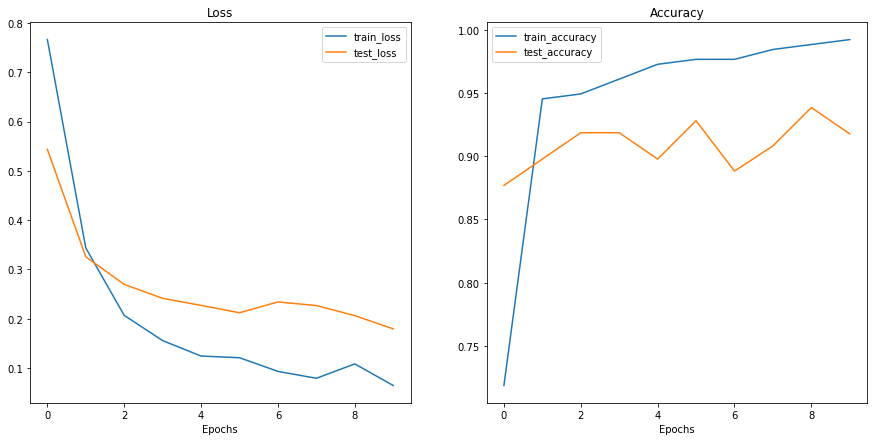

In [44]:
from helpers import plot_loss_curves

plot_loss_curves(pretrained_vit_results)


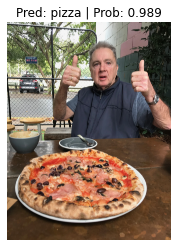

In [45]:
import requests

# Import function to make predictions on images and plot them
from modulo.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get(
            "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)


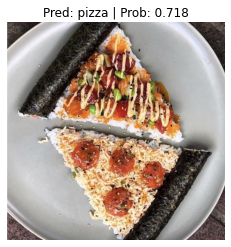

In [46]:
# Setup custom image path
custom_image_path = image_path / "04-pizzaa-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get(
            "https://cdn.vox-cdn.com/thumbor/z8j8smc8QMQ0Opn1UK7fAyurwto=/1400x1400/filters:format(jpeg)/cdn.vox-cdn.com/uploads/chorus_asset/file/13274183/unnamed.jpg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)


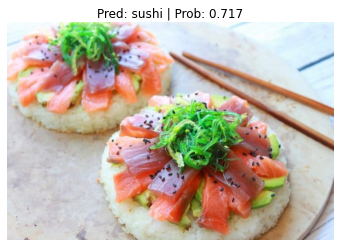

In [48]:
# Setup custom image path
custom_image_path = image_path / "04-pizzaaa-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get(
            "https://www.asiancaucasian.com/wp-content/uploads/2017/02/Sushi-Pizza_600x400.jpg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)


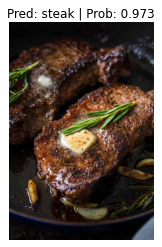

In [49]:

# Setup custom image path
custom_image_path = image_path / "04-pizzaaaa-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get(
            "https://natashaskitchen.com/wp-content/uploads/2020/03/Pan-Seared-Steak-4.jpg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)


### Looks like it works!